# Recommender System for Movies
This project is set up to build a neuronal network with the data of the movielens 100K data set to give a user a recommendation for movies.
## Project goal
The network recommends movies to a given user with specific demographic information, which fit his interests best.
The steps in the model are as follows:
1. Map user ID to a "user vector" via an embedding matrix.
2. Map movie ID to a "movie vector" via an embedding matrix.
3. Compute the dot product between the user vector and movie vector, to obtain the match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

## Package Import

In [10]:
from pathlib import Path
from zipfile import ZipFile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

## Data Import

In [11]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

## Preprocessing
First, need to perform some preprocessing to encode users and movies as integer indices


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## Preparing training and validation data

In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model
We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).

In [6]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model based on the data split

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 7s 4ms/step - loss: 0.6359 - val_loss: 0.6201
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6131 - val_loss: 0.6178
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6084 - val_loss: 0.6138
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6077 - val_loss: 0.6159
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6070 - val_loss: 0.6123


## Plot training and validation loss

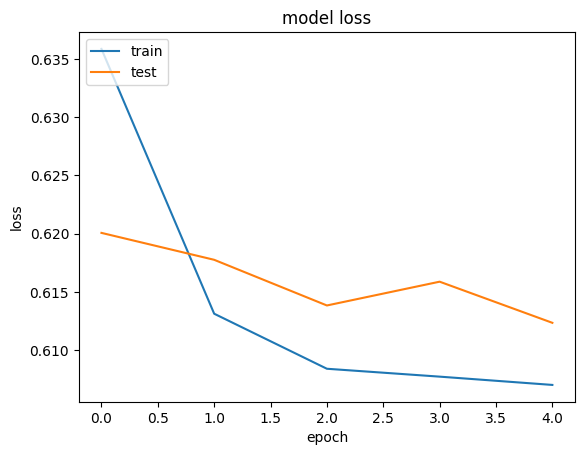

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user

In [9]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

301/301 [==============================] - 0s 885us/step
Showing recommendations for user: 415
Movies with high ratings from user
--------------------------------
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Goodfellas (1990) : Crime|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Hoop Dreams (1994) : Documentary
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Brazil (1985) : Fantasy|Sci-Fi
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Full Metal Jacket (1987) : Drama|War
Amadeus (1984) : Drama
Office Space (1999) : Comedy|Crime
Finding Nemo (2003) : A

## Citation
Dataset: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

Beginning: https://keras.io/examples/structured_data/collaborative_filtering_movielens/